In [1]:
import pandas as pd
import numpy as np
import altair as alt
from altair import datum, expr
import matplotlib.pyplot as plt
import datetime as dt
alt.renderers.enable('notebook')
pd.set_option('display.max_colwidth', -1)

In [2]:
tchrs = pd.read_stata("teacher_data.dta", convert_categoricals=False)
csos = pd.read_stata("cso_data.dta", convert_categoricals=False)
dirs = pd.read_stata("director_data.dta", convert_categoricals=False)

In [3]:
print(f"The Teacher dataset contains {tchrs.shape[0]} records\nThe CSO dataset contains {csos.shape[0]} records\nThe Director dataset contains {dirs.shape[0]} records")

The Teacher dataset contains 810 records
The CSO dataset contains 150 records
The Director dataset contains 238 records


The main questions we want to ask are documented in the [analysis plan](https://github.com/TSSlade/tusome-d4dm/blob/master/analysis_plan.md), which is an evolving document.

## Teacher Instrument

Here we begin exploring the data we obtained from interviewing the teachers.

In [4]:
tchr_ct = tchrs.shape[0]

Our dataset contains interviews with {{tchr_ct}} teachers.

### Teachers visited previously by CSOs

The underlying assumption of most of the interview protocol is that the teacher has had a coaching interaction with a CSO. The first issue we should then address is the proportion of teachers who have received a visit from a CSO.

In [5]:
never = 100 * ((tchr_ct - tchrs.vis_before.sum())/tchr_ct)

We see that {{np.round(never, decimals=2)}}% of teachers interviewed had never been previously visited by CSOs.

### Number of coaching visits in the last academic term

We have confirmed that the overwhelming majority of our teachers have been visited. We can have greater confidence in the responses they give us over the course of the interview if they have had a visit in the recent past. We therefore asked the teachers to tell us how many times they had been visited by their CSO in the preceding academic term (Term 2 of the Kenyan academic year, running from roughly May-July 2018).

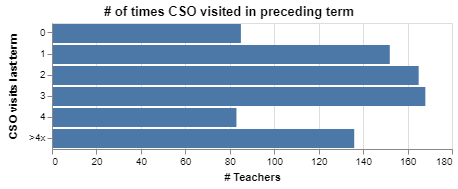

In [6]:
tchrs.vis_before_freq = tchrs.vis_before_freq.replace({55: ">4x"})
viscount_df = pd.DataFrame(tchrs.vis_before_freq.value_counts(sort=False)).rename_axis("prevterm_vis").reset_index()
viscount_df["pct"] = np.round(100 * (viscount_df.vis_before_freq / tchrs.vis_before.sum()), decimals=2)
more_than_monthly = viscount_df[viscount_df.prevterm_vis.isin([4, ">4x"])].pct.sum()
alt.Chart(viscount_df, title="# of times CSO visited in preceding term").mark_bar().encode(
    alt.Y("prevterm_vis:O", title="CSO visits last term"),
    alt.X("vis_before_freq:Q", title="# Teachers"),
    tooltip="pct")

We see that roughly {{viscount_df[viscount_df.prevterm_vis==0].pct[0]}}% of the respondents, while they'd been visited by a CSO in the past, had not been visited in the preceding term. However, {{viscount_df[viscount_df.prevterm_vis.isin([1, 2, 3])].pct.sum()}}% of the respondents were visited between once per term and once per month. {{more_than_monthly}}% of the teachers were visited by their CSOs more frequently than monthly.

### CSOs' activities during last coaching visit

We are interested in knowing what CSOs are focusing on when they pay a visit to a school. Are they observing a lesson? Are they giving feedback to the teacher? Do they assess pupils' fluency rates? Do they take advantage of their presence at the school to meet with the head teacher (HT)? What kinds of things are they doing _besides_ these activities?

In [7]:
visact_df = pd.DataFrame.from_dict({"activities": ["Assessed pupils",
                                                   "Talked to HT",
                                                   "Provided feedback on lesson",
                                                   "Had general talk",
                                                   "Other"],
                                    "tchrs_reporting": [tchrs[tchrs.vis_before != 0].vis_act_kids.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_ht.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_fdbk.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_gen.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_other.sum()]})
visact_df["pct"] = np.round(visact_df.tchrs_reporting.apply(lambda x: 100 * (x/(tchr_ct - never))), decimals=2)
visact_df

,activities,tchrs_reporting,pct
0,Assessed pupils,675,84.06
1,Talked to HT,511,63.64
2,Provided feedback on lesson,721,89.79
3,Had general talk,357,44.46
4,Other,125,15.57


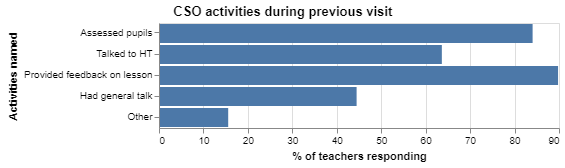

In [8]:
alt.Chart(visact_df, title="CSO activities during previous visit").mark_bar().encode(
alt.Y("activities:O", 
      title="Activities named",
      sort = alt.EncodingSortField(field="tchrs_reporting", op="values", order="ascending")),
alt.X("pct:Q",
      title="% of teachers responding"),
tooltip = "tchrs_reporting")

Nearly {{int(np.ceil(visact_df.pct.max()))}}% of teachers report that when the CSO last visited, s/he provided feedback on a lesson. Nearly the same quantity said that the CSO assessed pupils. Neither of these is surprising, as those activities are key features of a "reimbursable" or "valid" lesson observation. If anything, it is interesting that these numbers are not higher, given that we have excluded from our denominator those teachers who said they had never received a visit from the CSO.

Of note is the relatively low proportion of teachers reporting the CSO had spoken with the HT. While Tusome encourages CSOs to speak with HTs as part of the standard protocol for visiting a school, it is not explicitly considered as a factor for reimbursement of transportation costs for visiting that school.

That said, it is also possible that teachers may simply not be aware of activities taking place outside of their classroom. They and their classrooms would have been the objects of the lesson observation and fluency assessment; they may not have as much visibility into what happened before or after the CSO entered their classroom.

A little over {{int(np.floor(visact_df[visact_df.activities=="Other"].pct))}}% of teachers reported the CSO conducted an activity that was not listed in the questionnaire. Below we have sampled 20 of the things that they reported which were not captured in the questionnaire.

In [30]:
print(tchrs[tchrs.vis_act_other_det.notna() & (tchrs.vis_act_other_det != "")].vis_act_other_det.sample(20))

160    Talks to other staff memebers.                                                                                                                                                                                                                                                                                                 
467    He always notifys me through the HT that he will come to support us on a given day.                                                                                                                                                                                                                                            
438    look for GPS,asks my details including lesson                                                                                                                                                                                                                                                                                  
491    shortage of 

### CSOs using tablets or pen & paper during observation

The _Tangerine:Tutor_ app was developed with the intent and belief that CSOs would use it _while observing_ the lesson. However, Tusome staff report that not all CSOs find the tablet interface comfortable, and not all use it with ease. So we asked teachers to report whether CSOs use the tablets during the lesson observation, and also whether they use pen and paper.

Roughly {{int(np.round(100 * (tchrs.cso_usetab_yn.sum()/tchr_ct), decimals=2))}}% of teachers reported that the CSOs use tablets during lesson observation; roughly {{int(np.round(100 * (tchrs.cso_usepcl_yn.sum()/tchr_ct), decimals=2))}}% of teachers reported the CSOs use pen and paper during the lesson observation.

In [10]:
tabs_n_pencils = pd.crosstab(tchrs.cso_usetab_yn, tchrs.cso_usepcl_yn)

In [11]:
# tabs_n_pencils.rename(columns=["No pen", "Uses pen"])
tabs_n_pencils = tabs_n_pencils.rename_axis("Uses tablet").rename_axis("Uses pen and paper", axis="columns")
tabs_n_pencils = tabs_n_pencils.rename({0: "No", 1: "Yes"}, axis="columns").rename({0: "No", 1: "Yes"}, axis="index")
tabs_n_pencils

Uses pen and paper,No,Yes
Uses tablet,,
No,3,17
Yes,72,644


We see that the overwhelming majority of CSOs are using both tablets _and_ pen-and-paper systems when observing the teachers' lesson. There have historically been some instruments/data that CSOs were tasked by TSC to complete that were not rendered in _Tangerine_ format on the tablets; as of midway through Term 3 of the 2018 academic year, those instruments (mostly for the TSC's TPAD \[Teacher Professional Appraisal and Development\] project) are now in _Tangerine_. While the use of pen and paper does not appear to have come at the expense of using the tablets - indeed, it appears to be complementary, as nearly all CSOs are using both - Tusome should nonetheless follow up on these reports of CSOs' usage of pen and paper to understand the roots of the practice.

### CSOs' usage of the tablets to assess pupils' performance

Tusome's coaching protocol requires CSOs to randomly select three children from the classroom at the end of the lesson to assess their reading fluency. The prompt the children are to read from is a laminated sheet of paper with a short passage printed on it; the CSOs are instructed to use the tablet to record the children's responses. The tablet is then able to calculate fluency rates and store those as data associated with that observation.

Approximately {{int(np.round(100 * (tchrs.cso_usetab_pup_yn.sum()/tchr_ct), decimals=2))}}% of the teachers reported that CSOs use the tablets to assess children's reading fluency.

### Teachers' experience of feedback, and CSOs' use of tablets

Tusome asked teachers whether the CSO gave feedback on the lesson last time s/he paid a visit, whether s/he used the tablet to do so, and whether the teacher was able to recall specific feedback the CSO provided.

In [12]:
feedback = {"CSO gave feedback": tchrs.cso_gave_fdbk_yn.sum(),
            "CSO used a tablet": tchrs.cso_usetab_fdbk_yn.sum(),
            "Tchr remembers feedback": tchrs.cso_fdbk_remember.sum()}
fdbk_df = pd.DataFrame.from_dict(feedback, orient="index", columns=["ct"])
fdbk_df["pct"] = 100 * np.round(fdbk_df["ct"] / tchrs.shape[0], decimals=3)
fdbk_df = fdbk_df.rename_axis("event").reset_index()
fdbk_df

,event,ct,pct
0,CSO gave feedback,744.0,91.9
1,CSO used a tablet,664.0,82.0
2,Tchr remembers feedback,713.0,88.0


In [31]:
tchrs[tchrs.cso_fdbk_det.notna() & (tchrs.cso_fdbk_det != "")].cso_fdbk_det.sample(20)

781    He advised me to improve on the reading speed of my pupils by giving them more reading work                                                                                                                           
229    Timing myself well so as not to eat into the next lesson's time.                                                                                                                                                      
451    increase the involvement of learners through the i/we/you do, i move round the class to monitor what the learners are doing and support                                                                               
270    CSO told me to help the children use punctuation marks like fullstop when reading. They should know when to stop and when to read continously. He emphasized in using of teaching aids in explaining vocabulary words.
643    He told me to teach one vocabulary item one at a time, He said that when I writing all the words on the b

## CSO Instrument

Here we begin exploring the data we obtained from interviewing the CSOs.

### Length of experience using tablet-based Tangerine
_When did you first receive a tablet from Tusome or PRIMR?_

We want to convert the year/month CSOs provided into a number so we can work with it easily. We'll make the simplifying assumption that the tablet was received on the first day of the month they provided, and that this interview was conducted on the first day of the month. Neither of those are true, but the marginal days are unlikely to make a practical difference in a CSO's facility with the tool.

In [14]:
now = dt.datetime(2018, 10, 1)
csos["tab_usage"] = pd.to_timedelta(now - pd.to_datetime({"year": csos.recd_tab_yr, "month": csos.recd_tab_month, "day": 1})).dt.days

We'll also want to convert the duration to months, since that will be easier to digest, and filter out any missing values.

In [15]:
tab_usage = pd.DataFrame(csos[csos.tab_usage.notna()].tab_usage / 30)
# tab_usage

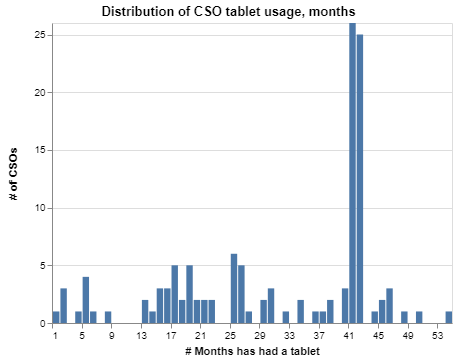

In [16]:
alt.Chart(tab_usage, title="Distribution of CSO tablet usage, months").mark_bar().encode(
    alt.X("tab_usage:Q", 
          bin=alt.BinParams(step=1), title="# Months has had a tablet"),
    alt.Y("count()", title="# of CSOs"))

We see that the majority of our CSOs have had their tablets for roughly {{int(tab_usage.tab_usage.mode()[0])}} months ({{np.round(tab_usage.tab_usage.mode()[0]/12, decimals=1)}} years). This is in keeping with the beginning of the Tusome program, and is as expected. CSOs who have had their tablets for longer are likely veterans of the PRIMR program (Tusome's predecessor); those who have had tablets for fewer months may have assumed their roles more recently. (CSO turnover due to retirement, promotion, maternity leave, etc. is an issue which Tusome is constantly needing to manage.)

### Proportion of CSOs reporting use of each application

_Which applications do you use frequently when supporting teachers? ...After recording unprompted responses, read the list of options and record responses._
  + Tangerine Tutor
  + Papaya
  + Tusome Books (in Adobe Acrobat)
  + Tusome Videos (in MX Player)

The CSOs' tablets come equipped with several tools meant to support their efforts as instructional coaches. These include the [_Tangerine:Tutor_](http://www.tangerinecentral.org/tutor/) application, the [_Papaya_](http://schoolsnetkenya.com/tusome-early-literacy-programme-sounds-application/) application, PDF versions of Tusome's instructional materials (pupil's books and teacher's guides), and videos that model effective instructional delivery.

We are interested in which of those tools CSOs use, and how frequently. We will provide an analysis of their unprompted free-response answers to the question above. For the moment, we note the tools they said they use when we explicitly prompted them with the list of tools available.

In [17]:
app_users = {"tutor": csos.freqapps_tt_promp.sum(),
         "papaya": csos.freqapps_papaya_promp.sum(),
         "books": csos.freqapps_bks_promp.sum(),
         "videos": csos.freqapps_vids_promp.sum()}
app_usage = pd.DataFrame.from_dict(app_users, orient="index", columns=["ct"])
app_usage["pct"] = 100 * np.round(app_usage["ct"] / csos.shape[0], decimals=3)
app_usage = app_usage.rename_axis("app").reset_index()

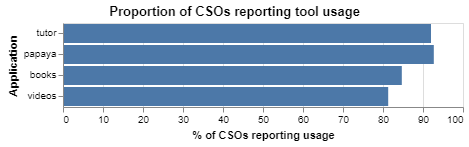

In [18]:
alt.Chart(app_usage, title="Proportion of CSOs reporting tool usage").mark_bar().encode(
    alt.Y("app:O",
          title="Application",
          sort = alt.EncodingSortField(field="pct", op="values", order="ascending"),
          ),
    alt.X("pct:Q", title="% of CSOs reporting usage"),
    tooltip="pct")

The overwhelming majority of the CSOs report using all of the applications. That said, the videos and books are used less frequently.

### Proportion of CSOs who refer to Tangerine to provide post-observation feedback

_Do you refer to Tangerine when giving teachers feedback after observing a lesson?_

The _Tangerine:Tutor_ application analyzes the pattern of the CSO's responses to the observation items and surfaces actionable feedback that could be share with the teacher to improve her or his instruction. While the auto-generated feedback is intended as a tool to help CSOs give more effective guidance to teachers, it can be quite extensive and is not prioritized. We were interested to know whether the CSOs make reference to the application's auto-generated feedback when they hold their post-observation debriefing session with the teacher.

In [19]:
100 * np.round(csos.ref_tang_fdbk.sum() / csos.shape[0], decimals=3)

96.7

Again, the overwhelming majority of CSOs report using the auto-generated feedback when holding their debrief session with the teacher. We will separately provide an analysis of their open-ended answers regarding _what_ they refer to and what they find most useful.

### Proportion of CSOs who use Tangerine to plan their work

_Do you refer to Tangerine to help you plan your work when you are **not** either observing a teacher or giving the teacher feedback?_

Version 3 of the _Tangerine:Tutor_ application features a screen which allows a CSO to see schools they have visited and which they have not. We were interested to know whether the CSOs are leveraging this feature—or others, such as the pupils' fluency rates, which are reported in the feedback—to make decisions about which schools to visit in the future.

In [20]:
100 * np.round(csos.refer_tang_nonobs.sum() / csos.shape[0], decimals=3)

60.0

Fewer than two-thirds of CSOs refer to Tangerine to plan their work. A sampling of their reasons is provided surfaced below:

In [21]:
pd.set_option('display.max_colwidth', -1)
csos[csos.tang_nonobs_nowhynot.notnull() & (csos.tang_nonobs_nowhynot != "")].tang_nonobs_nowhynot.sample(10)

39     I just use it to observe lessons                                                                                         
100    I only use it in schools                                                                                                 
6      I think that I only need to use it when I am at a school doing observations                                              
96     Tangerine might capture GPS and you will be seen like a cheat and it's not good. I only use it while supporting teachers.
149    i use my notebook to record my intended activities                                                                       
52     I normally use it when i am in class, that is what i believe it is ment for. I only use papaya.                          
130    I only use it for CLO only.                                                                                              
74     i fear to accidentally inerrupt the tangerine                                             

This result surfaces a few issues Tusome might consider addressing next time CSOs receive a refresher training on Tangerine's use.
  1. A lack of awareness of how the information provided by the tablet (schools visited and not visited) could be operationalized
  1. A fear that they would be accused of falsifying observation data, rooted specifically in a misunderstanding of the application's GPS-capture functionality
  1. A mental compartmentalization of Tangerine as being a Tusome-specific tool, not for use in broader contexts

Other reasons given suggest that the need which Tangerine might fill is already being addressed separately.
  1. The CSO keeps a personal record (outside of the tablet) in which they track school visitation
  1. The CSO has prepared a work schedule, and uses that as their guide until the month's activities have concluded.

### Frequency with which users refer to the application

\[If the CSO refers to the Tangerine for planning purposes\], _how often do you reference the data?_



In [22]:
tchk_freq = csos[csos.freq_refer_tang_plan.notna()].freq_refer_tang_plan.sort_values().value_counts(sort=False).to_frame(name="ct")
tchk_freq = tchk_freq.rename_axis("frequency").reset_index()
tchk_freq["frequency"] = tchk_freq["frequency"].replace({
    1: "Daily", 
    2: "Weekly",
    3: "Monthly",
    4: "Termly"})
tchk_freq["sort_order"] = tchk_freq.index

It appears that among the CSOs who check the application, it is most common to check it at least weekly.

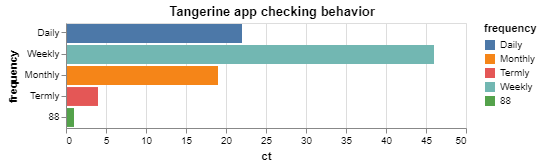

In [23]:
alt.Chart(tchk_freq, title="Tangerine app checking behavior").mark_bar().encode(
    alt.X("ct:Q"),
    alt.Y("frequency:O", sort = alt.EncodingSortField(field="sort_order:Q", op="values", order="ascending")),
    color = "frequency")

### CSO reference to the Tangerine Dashboard

_In the last term, how often did you look at the Tangerine Dashboard?_

The data that is generated by the CSOs' lesson observations is uploaded to the cloud and reported on the [Tangerine Dashboard](http://tools.tusome.tangerinecentral.org/_csv/report/group-national_tablet_program/00b0a09a-2a9f-baca-2acb-c6264d4247cb,c835fc38-de99-d064-59d3-e772ccefcf7d/2018/1/ep8yqMKT.html#tutor). This Dashboard is reviewed by senior management within the Ministry of Education: the Principal Secretary, his Directors, and their deputies. It is also sent to the Directors of MOE and TSC at the County level. As these latter personnel oversee the CSOs, the Dashboard may have an effect ...

In [24]:
ip=get_ipython()
locate_dir = ip.ipython_dir
profile_dir = ip.config.ProfileDir.location
print("IPython location: %s" % locate_dir)
print("IPython profile location: %s" % profile_dir)


IPython location: C:\Users\tslade\.ipython
IPython profile location: <traitlets.config.loader.LazyConfigValue object at 0x00000242EDAB8C18>


In [25]:
import os
extra_paths = ip.config.NotebookApp['extra_static_paths']
static_paths = os.path.join(profile_dir,'static')
if type( extra_paths ) is list:
    static_paths = extra_paths + static_paths
print("The custom.js file will be searched in this list of directories: %s" % static_paths)

TypeError: expected str, bytes or os.PathLike object, not LazyConfigValue

In [ ]:
static_paths = os.path.join(profile_dir,'static')

In [ ]:
import os
import re
for static_path in static_paths:
    custom_js = os.path.join(static_path,'custom', 'custom.js')
    if os.path.isfile(custom_js) is True:
        print("custom.js found in %s" % custom_js)
        break

In [28]:
test = 91.1
int(test)

91

In [41]:
tab_usage.tab_usage.mode()

0    41.633333
dtype: float64